In [289]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import load_diabetes
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import seaborn as sns
import plotly.express as px
import shap
%matplotlib inline

- This notebook contains code for creating the binary classification model using the ACS5 dataset from the US Census Bureau merged with the Bank Desert Status target variable. 

In [290]:
# read census data for modeling 
acs5_file_path = r'C:\Users\jocel\OneDrive\Documents\University_of_Denver\COMP 4447 DS Tools 1\Final Project\Bank-Deserts-Phenomenon\exploratory_data_analysis\acs5_final.parquet'

census_df = pd.read_parquet(acs5_file_path)
census_df.head()

,GEOID,Census Tract Name,House Units,Income,Poverty%,Employment%,Disability%,VacantHous%,OwnOcpHous%,Majority Race,...,Minority Race Percentage,Majority Gender,Majority Gender Percentage,Minority Gender,Majority Age,Majority Age Percentage,Minority Age,Community Type,Bank Desert Status,Population Density
0,01001020100,Census Tract 201; Autauga County; Alabama,733,60563.0,0.153351,0.974255,0.200000,0.045020,0.708049,White%,...,0.111528,Male%,0.519035,Female%,18_64%,0.565684,Under18%,Urban,bank desert,491.621258
1,01001020300,Census Tract 203; Autauga County; Alabama,1431,77371.0,0.100802,0.981748,0.158362,0.088050,0.637317,White%,...,0.250859,Female%,0.539805,Male%,18_64%,0.603666,Under18%,Urban,bank desert,1690.742249
2,01001020400,Census Tract 204; Autauga County; Alabama,1722,73191.0,0.102333,0.990933,0.222222,0.032520,0.758420,White%,...,0.074492,Male%,0.510158,Female%,18_64%,0.593930,65+%,Urban,bank desert,1617.454021
3,01001020501,Census Tract 205.01; Autauga County; Alabama,1857,79953.0,0.078379,0.994409,0.173016,0.039849,0.522886,White%,...,0.150449,Female%,0.534336,Male%,18_64%,0.685028,Under18%,Urban,potential bank desert,1720.492632
4,01001020600,Census Tract 206; Autauga County; Alabama,1551,64904.0,0.151081,0.969313,0.158896,0.135397,0.700193,White%,...,0.173743,Female%,0.536338,Male%,18_64%,0.531388,Under18%,Urban,potential bank desert,1236.425983


In [291]:
census_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59872 entries, 0 to 59872
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GEOID                       59872 non-null  object 
 1   Census Tract Name           59872 non-null  object 
 2   House Units                 59872 non-null  int64  
 3   Income                      59872 non-null  float64
 4   Poverty%                    59872 non-null  float64
 5   Employment%                 59872 non-null  float64
 6   Disability%                 59872 non-null  float64
 7   VacantHous%                 59872 non-null  float64
 8   OwnOcpHous%                 59872 non-null  float64
 9   Majority Race               59872 non-null  object 
 10  Majority Race Percentage    59872 non-null  float64
 11  Minority Race               59872 non-null  object 
 12  Minority Race Percentage    59872 non-null  float64
 13  Majority Gender             59872 no

In [292]:
# ran this dataset through a correlation matrix to check numerical columns that are highly correlated 
# let's look at categorical columns
census_df.describe(include = 'object')

,GEOID,Census Tract Name,Majority Race,Minority Race,Majority Gender,Minority Gender,Majority Age,Minority Age,Community Type,Bank Desert Status
count,59872,59872,59872,59872,59872,59872,59872,59872,59872,59872
unique,59872,59872,5,5,2,2,3,3,4,3
top,01001020100,Census Tract 201; Autauga County; Alabama,White%,Hispanic%,Female%,Male%,18_64%,Under18%,Urban,bank desert
freq,1,1,46056,23721,32905,33000,59078,40252,49477,37864


In [293]:
census_df['Community Type'].value_counts()

Community Type
Urban       49477
Suburban     5314
Rural        5074
Unknown         7
Name: count, dtype: int64

In [294]:
# drop 'Unknown rows' in Community Type
census_df = census_df[census_df['Community Type'] != 'Unknown']

In [295]:
# since gender is directly related let's drop minority gender 
census_df.drop(columns = ['GEOID', 'Census Tract Name', 'Minority Gender', 'Minority Race', 'Minority Age'], inplace = True)

In [296]:
# replacing the categorical values in bank desert status column to labels 
# for multi-class
# census_df['Bank Desert Status'] = census_df['Bank Desert Status'].replace({
#     'not a bank desert': 0, 
#     'potential bank desert': 1, 
#     'bank desert': 2
# })


# for binary 
# combine not a bank desert and potential bank desert as 0 and bank desert as 1
census_df['Bank Desert Status'] = census_df['Bank Desert Status'].replace({
    'not a bank desert': 0, 
    'potential bank desert': 0, 
    'bank desert': 1
})

C:\Users\jocel\AppData\Local\Temp\ipykernel_372904\3727263318.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  census_df['Bank Desert Status'] = census_df['Bank Desert Status'].replace({


In [297]:
# census_df.to_parquet('census_with_bsd.parquet')

In [298]:
# let's one hot encode the categorical variables

census_encoded_df = pd.get_dummies(census_df, columns = ['Majority Race', 'Majority Gender', 'Majority Age', 'Community Type'], dtype = 'int', drop_first = True)

In [299]:
census_encoded_df

,House Units,Income,Poverty%,Employment%,Disability%,VacantHous%,OwnOcpHous%,Majority Race Percentage,Minority Race Percentage,Majority Gender Percentage,...,Population Density,Majority Race_Black%,Majority Race_Hispanic%,Majority Race_TwoOrMore%,Majority Race_White%,Majority Gender_Male%,Majority Age_65+%,Majority Age_Under18%,Community Type_Suburban,Community Type_Urban
0,733,60563.0,0.153351,0.974255,0.200000,0.045020,0.708049,0.804290,0.111528,0.519035,...,491.621258,0,0,0,1,1,0,0,0,1
1,1431,77371.0,0.100802,0.981748,0.158362,0.088050,0.637317,0.691008,0.250859,0.539805,...,1690.742249,0,0,0,1,0,0,0,0,1
2,1722,73191.0,0.102333,0.990933,0.222222,0.032520,0.758420,0.879609,0.074492,0.510158,...,1617.454021,0,0,0,1,1,0,0,0,1
3,1857,79953.0,0.078379,0.994409,0.173016,0.039849,0.522886,0.796166,0.150449,0.534336,...,1720.492632,0,0,0,1,0,0,0,0,1
4,1551,64904.0,0.151081,0.969313,0.158896,0.135397,0.700193,0.742120,0.173743,0.536338,...,1236.425983,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59868,1267,73096.0,0.105516,1.000000,0.213829,0.211523,0.644830,0.805356,0.253797,0.536371,...,2.840035,0,0,0,1,1,0,0,1,0
59869,1580,56627.0,0.065390,0.981280,0.105020,0.134810,0.644937,0.910502,0.063738,0.532034,...,1.356660,0,0,0,1,1,0,0,0,0
59870,1128,61087.0,0.038743,0.995675,0.130435,0.159574,0.542553,0.832975,0.247094,0.565217,...,3018.534206,0,0,0,1,1,0,0,0,0
59871,1557,67715.0,0.140153,0.946086,0.139542,0.118176,0.806680,0.838168,0.130382,0.551756,...,1.390526,0,0,0,1,1,0,0,0,0


In [300]:
# let's split our data into training and test set 

X = census_encoded_df.drop(columns = ['Bank Desert Status'])
y = census_encoded_df['Bank Desert Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [301]:
y.value_counts()

Bank Desert Status
1    37860
0    22005
Name: count, dtype: int64

In [302]:
# create custom scoring metrics for cross_validate
# used weighted average for precision and recall to account for class imbalance (65/35) and to make sure majority class does not overshadow minority class
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted') 
}

In [303]:
X_test

,House Units,Income,Poverty%,Employment%,Disability%,VacantHous%,OwnOcpHous%,Majority Race Percentage,Minority Race Percentage,Majority Gender Percentage,...,Population Density,Majority Race_Black%,Majority Race_Hispanic%,Majority Race_TwoOrMore%,Majority Race_White%,Majority Gender_Male%,Majority Age_65+%,Majority Age_Under18%,Community Type_Suburban,Community Type_Urban
39298,2946,70623.0,0.103741,0.958691,0.141905,0.140869,0.728106,0.849159,0.089959,0.501742,...,153.843332,0,0,0,1,0,0,0,0,1
22560,2520,76326.0,0.059248,0.953754,0.138637,0.028175,0.868651,0.735482,0.133266,0.546156,...,1756.650346,0,0,0,1,0,0,0,0,1
18760,2080,48203.0,0.234886,0.901690,0.143707,0.112981,0.635577,0.781962,0.201933,0.547076,...,1256.245903,0,0,0,1,1,0,0,1,0
22011,1521,46648.0,0.226308,0.952437,0.198505,0.124260,0.698882,0.739312,0.225112,0.523169,...,553.853307,0,0,0,1,0,0,0,0,1
34172,1999,46283.0,0.407266,0.903879,0.025386,0.060530,0.255628,0.896050,0.132837,0.508699,...,12794.167812,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37077,2052,91154.0,0.170796,0.935943,0.140726,0.047758,0.538499,0.565793,0.197017,0.514313,...,89277.349961,0,0,0,1,1,0,0,0,1
21904,1123,92652.0,0.054113,0.969992,0.059163,0.000000,0.686554,0.837302,0.085498,0.567821,...,2743.422841,0,0,0,1,1,0,0,0,1
19915,1153,96324.0,0.165084,0.967814,0.079266,0.070252,0.570685,0.995414,0.000000,0.522437,...,1576.103748,0,0,0,1,1,0,0,0,1
51712,2214,42745.0,0.142292,0.950410,0.088352,0.180217,0.042909,0.441060,0.404790,0.531039,...,11231.717567,0,1,0,0,0,0,0,0,1


### Binary Logistic Regression

In [318]:
pipeline_logistic_binary = Pipeline([
    ('scaler', StandardScaler()),  # scale the data
    ('model', LogisticRegression())  # multi class logistic regression model
])

cv_log_binary = cross_validate(pipeline_logistic_binary, X_train, y_train, cv = 5, n_jobs = -1, verbose = 2, scoring = scoring)
cv_log_binary

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


{'fit_time': array([0.12169027, 0.11694074, 0.12479305, 0.12179494, 0.09539342]),
 'score_time': array([0.01731563, 0.01755905, 0.01896477, 0.01292539, 0.01343369]),
 'test_accuracy': array([0.67000731, 0.66677106, 0.6638129 , 0.66631865, 0.67717686]),
 'test_precision': array([0.65443798, 0.65018511, 0.64596372, 0.64945659, 0.66477115]),
 'test_recall': array([0.67000731, 0.66677106, 0.6638129 , 0.66631865, 0.67717686])}

In [319]:
print(f'Logistic Regression Average Accuracy over 5 folds: {cv_log_binary['test_accuracy']}')
print(f'Logistic Regression Average Precision over 5 folds: {cv_log_binary['test_precision']}')
print(f'Logistic Regression Average Recall over 5 folds: {cv_log_binary['test_recall']}')

Logistic Regression Average Accuracy over 5 folds: [0.67000731 0.66677106 0.6638129  0.66631865 0.67717686]
Logistic Regression Average Precision over 5 folds: [0.65443798 0.65018511 0.64596372 0.64945659 0.66477115]
Logistic Regression Average Recall over 5 folds: [0.67000731 0.66677106 0.6638129  0.66631865 0.67717686]


### Decision Trees

In [321]:
# features not needed to be scaled for tree based models
dt_binary = DecisionTreeClassifier(random_state = 42)

# cross validation for decision tree
cv_dt_binary = cross_validate(dt_binary, X_train, y_train, cv = 5, n_jobs = -1, verbose = 2, scoring = scoring)
cv_dt_binary

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


{'fit_time': array([0.85396767, 1.01529646, 1.01758385, 0.94599581, 1.03142118]),
 'score_time': array([0.01538014, 0.01544785, 0.01572251, 0.01241398, 0.01144624]),
 'test_accuracy': array([0.59787034, 0.60643073, 0.60221341, 0.60451034, 0.61234078]),
 'test_precision': array([0.60189237, 0.61062298, 0.6028778 , 0.60650088, 0.61347632]),
 'test_recall': array([0.59787034, 0.60643073, 0.60221341, 0.60451034, 0.61234078])}

In [322]:
print(f'Decision Tree Classifier Average Accuracy over 5 folds: {cv_dt_binary['test_accuracy']}')
print(f'Decision Tree Classifier Average Precision over 5 folds: {cv_dt_binary['test_precision']}')
print(f'Decision Tree Classifier Average Recall over 5 folds: {cv_dt_binary['test_recall']}')

Decision Tree Classifier Average Accuracy over 5 folds: [0.59787034 0.60643073 0.60221341 0.60451034 0.61234078]
Decision Tree Classifier Average Precision over 5 folds: [0.60189237 0.61062298 0.6028778  0.60650088 0.61347632]
Decision Tree Classifier Average Recall over 5 folds: [0.59787034 0.60643073 0.60221341 0.60451034 0.61234078]


In [323]:
rf_binary = RandomForestClassifier(random_state = 42)

cv_rf_binary = cross_validate(rf_binary, X_train, y_train, cv = 5, n_jobs = -1, verbose = 2, scoring = scoring)
cv_rf_binary

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.2s finished


{'fit_time': array([14.00941086, 14.05021143, 14.92381167, 14.29310989, 14.95083022]),
 'score_time': array([0.23065782, 0.24858284, 0.24864411, 0.20707941, 0.24345851]),
 'test_accuracy': array([0.68128197, 0.69245224, 0.68260597, 0.68970558, 0.69315097]),
 'test_precision': array([0.66798917, 0.68114207, 0.66951168, 0.67791052, 0.68197286]),
 'test_recall': array([0.68128197, 0.69245224, 0.68260597, 0.68970558, 0.69315097])}

### Random Forest - Hyperparameter tuning 
- Hyperparameter tune the model that returned the best accuracy, precision (weighted) and recall (weighted) over 5 cross validation folds
- We will use GridSearchCV for hyperparameter tuning to exhaustively search through every possible hyperparameter combinations in our parameter grid

In [325]:
# Define the parameter grid
rf_tuning_scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# this param grid resulted in a huge drop in recall (cross val recall is 97 to 88 in the testing set) which means the model potentially overfitted in the training model 
# param_grid_rf_binary = { 
#     'n_estimators': [100, 200],                   
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],                    
#     'min_samples_leaf': [2, 4, 6],          
#     'class_weight': ['balanced', None]  
# }

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # StratifiedKFold maintains the distribution of classes in each fold

param_grid_rf_binary1 = {
    'n_estimators': [100, 200],                   
    'max_depth': [5, 10, 12], # lower max depth to reduce overfitting
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [4, 6, 8],          
    'class_weight': ['balanced'] # balanced since there is a slight imbalance in the data
}


grid_search_rf_binary = GridSearchCV(rf_binary, 
                                     param_grid = param_grid_rf_binary1, 
                                     cv = skf, 
                                     n_jobs = -1, 
                                     verbose = 2, 
                                     scoring = rf_tuning_scoring, 
                                     refit = 'recall') # refit = recall since we are prioritizing recall -- this will choose the model with best recall

grid_search_rf_binary.fit(X_train, y_train)

cv_results_rf = grid_search_rf_binary.cv_results_

# get the best parameters and best score
print("Best hyperparameters: ", grid_search_rf_binary.best_params_)
print("Best cross-validation accuracy: ", grid_search_rf_binary.best_score_)

# access specific metrics
print("Best precision:", max(cv_results_rf['mean_test_precision'])) # weighted precision
print("Best recall:", max(cv_results_rf['mean_test_recall'])) # weighted recall 
print("Best F1-score:", max(cv_results_rf['mean_test_f1']))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best hyperparameters:  {'class_weight': 'balanced', 'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best cross-validation accuracy:  0.6783875947291313
Best precision: 0.7753665674387843
Best recall: 0.6783875947291313
Best F1-score: 0.7205346308267097


In [326]:
# standard deviation of recall across 5 cross validation folds

recalls_per_fold = [
    cv_results_rf['split0_test_recall'],
    cv_results_rf['split1_test_recall'],
    cv_results_rf['split2_test_recall'],
    cv_results_rf['split3_test_recall'],
    cv_results_rf['split4_test_recall']
]

# Convert to a 2D NumPy array
recalls_per_fold = np.array(recalls_per_fold)

# Now calculate the standard deviation across the rows (axis=1)
cv_std_recall = np.std(recalls_per_fold, axis=1)

# Output the result
print(f"Standard deviation of recall across folds: {cv_std_recall}")


Standard deviation of recall across folds: [0.02991558 0.0229293  0.03159361 0.02710408 0.02374894]


In [327]:
# get recall for each fold
fold_recall = [
    cv_results_rf[f'split{i}_test_recall'] for i in range(5)
]

# compute recall for each fold
recall_folds = np.array(fold_recall).mean(axis=1)  # Mean recall per fold
std_recall_folds = np.std(fold_recall, axis=1)  # Standard deviation per fold

print(f"Recall across 5 folds: {recall_folds}")
print(f"Standard deviation of recall across 5 folds: {std_recall_folds}")

Recall across 5 folds: [0.6459686  0.64239512 0.63725041 0.65924948 0.63831563]
Standard deviation of recall across 5 folds: [0.02991558 0.0229293  0.03159361 0.02710408 0.02374894]


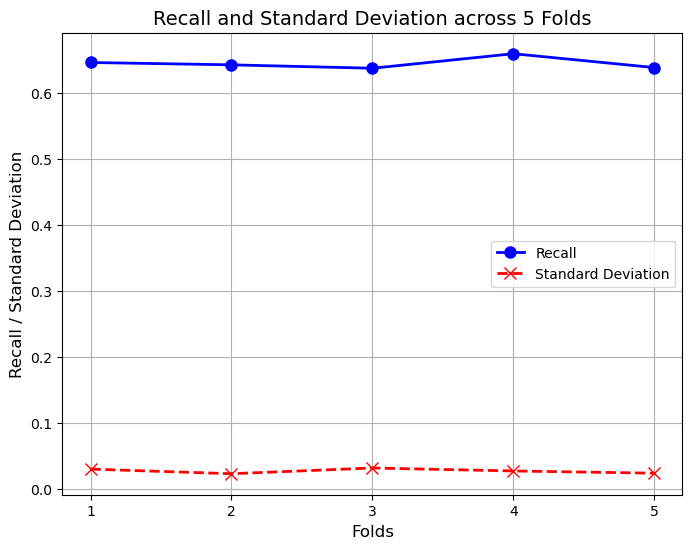

In [328]:
# plot recall and standard deviation for each fold
fig, ax = plt.subplots(figsize=(8, 6))

# plot recall
ax.plot(range(1, 6), recall_folds, label='Recall', marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)

# plot standard deviation in the same axes
ax.plot(range(1, 6), std_recall_folds, label='Standard Deviation', marker='x', color='red', linestyle='--', linewidth=2, markersize=8)

ax.set_title('Recall and Standard Deviation across 5 Folds', fontsize=14)
ax.set_xlabel('Folds', fontsize=12)
ax.set_ylabel('Recall / Standard Deviation', fontsize=12)
ax.legend()

plt.xticks(range(1, 6))
plt.grid(True)
plt.show()

### Testing best model on test data 
- Before testing the Random Forest Classifier, we had to make sure that 1) the model is not overfitting on the training data and 2) the model's standard deviation is stable

In [330]:
# use best estimator from grid search rf binary on testing data 

rf_binary_best_estimator = grid_search_rf_binary.best_estimator_
print(f'Best estimators from Random Forest GridSearchCV: {rf_binary_best_estimator}')

Best estimators from Random Forest GridSearchCV: RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42)


In [331]:
rf_binary_y_pred = rf_binary_best_estimator.predict(X_test)
rf_probs = rf_binary_best_estimator.predict_proba(X_test)[:,1]  # Get probabilities for class 1

In [332]:
# generate classification report

print(classification_report(y_test, rf_binary_y_pred))

              precision    recall  f1-score   support

           0       0.54      0.67      0.60      4401
           1       0.78      0.67      0.72      7572

    accuracy                           0.67     11973
   macro avg       0.66      0.67      0.66     11973
weighted avg       0.69      0.67      0.68     11973



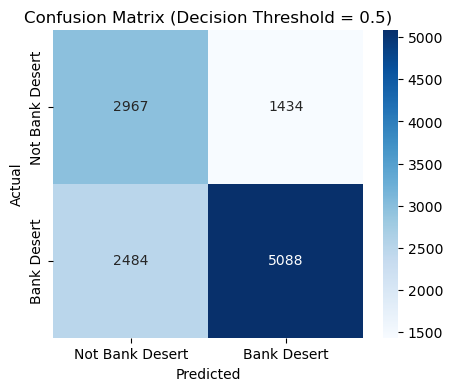

In [333]:
# confusion matrix 
cm = confusion_matrix(y_test, rf_binary_y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Bank Desert", "Bank Desert"], yticklabels=["Not Bank Desert", "Bank Desert"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Decision Threshold = 0.5)")
plt.show()

ROC-AUC Score: 0.7375


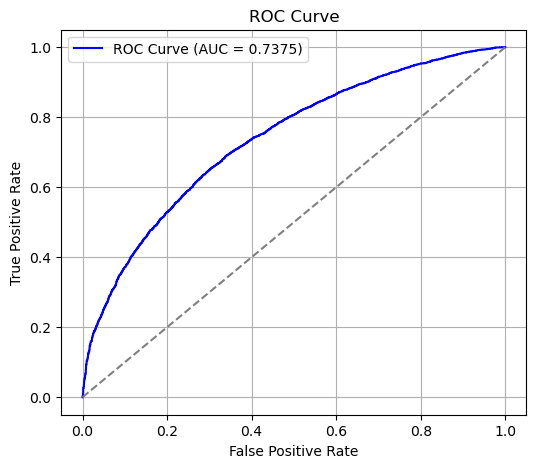

In [334]:
# compute ROC-AUC score
roc_auc = roc_auc_score(y_test, rf_probs)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# compute ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_probs)

# Plot ROC curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})", color="blue")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [335]:
# feature importances 

importances = grid_search_rf_binary.best_estimator_.feature_importances_
feature_names = X_train.columns

# display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)[:10]
importance_df.reset_index().drop(columns = ['index'])

,Feature,Importance
0,Population Density,0.190079
1,House Units,0.121047
2,OwnOcpHous%,0.103430
3,VacantHous%,0.064787
4,Community Type_Urban,0.060192
5,Minority Race Percentage,0.056551
6,Majority Race Percentage,0.053426
7,Majority Age Percentage,0.048413
8,Income,0.048239
9,Poverty%,0.046349


C:\Users\jocel\AppData\Local\Temp\ipykernel_372904\4212981731.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette = 'mako')


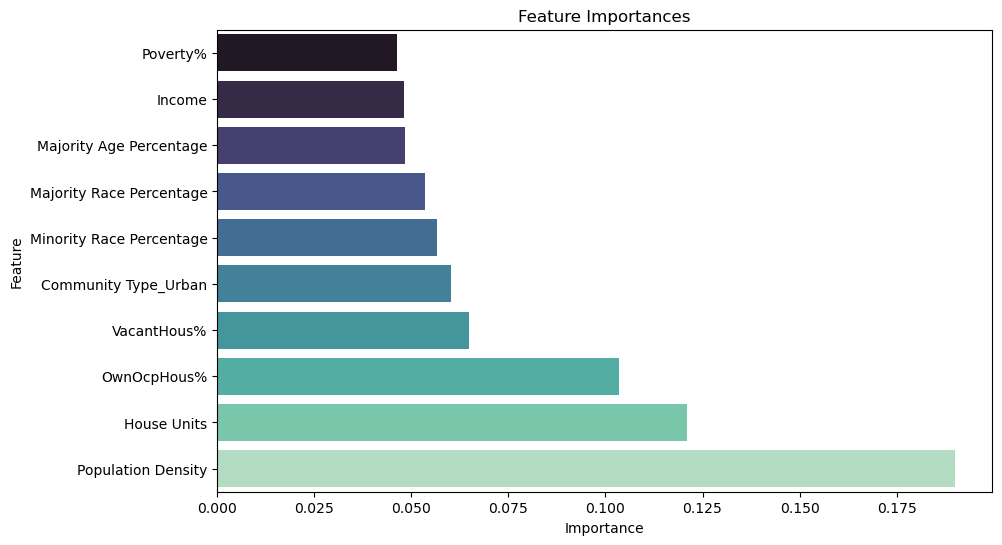

In [336]:
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette = 'mako')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [337]:
# changing decision threshold from 0.5 to 0.4 -- lower the threshold if want to prioritize recall

# set a lower threshold (e.g., 0.4 instead of 0.5)
new_threshold = 0.40
rf_binary_y_pred_adjusted = (rf_probs >= new_threshold).astype(int)

print(classification_report(y_test, rf_binary_y_pred_adjusted))

              precision    recall  f1-score   support

           0       0.63      0.40      0.49      4401
           1       0.71      0.86      0.78      7572

    accuracy                           0.69     11973
   macro avg       0.67      0.63      0.64     11973
weighted avg       0.68      0.69      0.68     11973



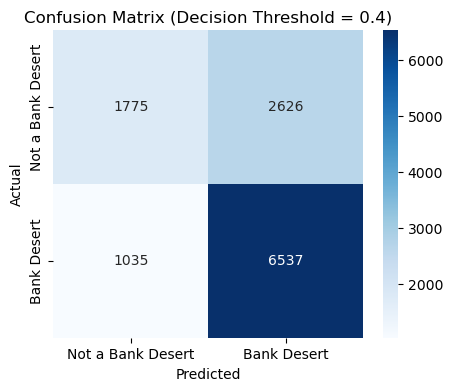

In [338]:
cm1 = confusion_matrix(y_test, rf_binary_y_pred_adjusted)

plt.figure(figsize=(5,4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=["Not a Bank Desert", "Bank Desert"], yticklabels=["Not a Bank Desert", "Bank Desert"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Decision Threshold = 0.4)")
plt.show()


### Notes

- Changing the decision threshold from 0.5 (default) to 0.4 increased the recall which means our model has less false negatives (less misclassified non-bank deserts that are actual bank deserts) and since our priority is to find financially underserved communites, we need to increase the recall. Even though this could potentially lead to classifying non-bank deserts as bank deserts (classifying a financially served community as underserved).

- Recall is the ability of a model to correctly identify all of the positive cases (in our case, bank desert). 

- A decision threshold of 0.5 means that the model does not favor one class over the other. 
Since we want to favor the positive class more (bank desert), we lowered the threshold to 0.4 making it easier for the model to classify instances as class 1/a bank desert.

### Prioritizing recall to identify more underserved communities (bank deserts)
One of the goals of this analysis is to identify financially underserved communities (bank deserts) using socioeconomic factors (e.g., Population Density, Housing Units, Poverty, Income) sourced from the US Census Bureau.

Prioritizing recall ensures that no underserved areas are overlooked. In this context, recall helps maximize the identification of all bank deserts, ensuring that no potential underserved community is missed. This is crucial for targeting financial inclusion efforts. By prioritizing recall, we align with the goals of financial regulators like the FDIC and NCUA, who aim to improve financial inclusion and stability by providing communities with access to services like savings accounts, mortgages, and loans.

At what cost?
The tradeoff is lower precision, which means we might classify some financially served communities as underserved. However, this approach doesn’t neglect precision; it simply prioritizes recall to ensure that underserved communities are identified. Financial regulators, policymakers, and institutions often follow a systematic framework before taking action, which helps mitigate the impact of lower precision. Additionally, these organizations have broader access to data and financial resources, allowing them to refine their targeting over time, thus improving precision without sacrificing the primary objective of financial inclusion.

### SHAP analysis
- Extracting feature importances from our random forest classifier does not necessarily equate to extracting the best predictors in the model. It just tells us which features were the biggest influence to the target variable but we dont know whether this influence positively contributed to predicting bank deserts or the other way around. This is where SHAP analysis comes into play.
- SHAP is a method that explains how individual predictions are made by a machine learning model.
- In the case of the bank desert analysis, our f(x) or y (think of it as the output of the ML model) is a predicted probability, this predicted probability then tells us whether a particular instance belongs to class 0 or class 1. 

In [401]:
# Initialize SHAP Explainer
explainer = shap.TreeExplainer(rf_binary_best_estimator)

# Compute SHAP values for the **test set**
shap_values = explainer.shap_values(X_test)

# Print shape of SHAP values for both classes
# print("SHAP values for class 0 shape:", shap_values[0].shape)  # Class 0 (negative class)
# print("SHAP values for class 1 shape:", shap_values[1].shape)  # Class 1 (positive class)

# # Print shape of X_test
# print("X_test shape:", X_test.shape)

shap_values

array([[[ 5.12927004e-02, -5.12927004e-02],
        [-3.03357282e-03,  3.03357282e-03],
        [ 2.22937780e-03, -2.22937780e-03],
        ...,
        [ 3.00116441e-06, -3.00116441e-06],
        [ 2.77165282e-03, -2.77165282e-03],
        [-6.39850685e-02,  6.39850685e-02]],

       [[ 7.47118809e-02, -7.47118809e-02],
        [-2.23373057e-03,  2.23373057e-03],
        [-2.83323620e-04,  2.83323620e-04],
        ...,
        [ 2.90845337e-06, -2.90845337e-06],
        [ 1.96047926e-03, -1.96047926e-03],
        [-1.62773218e-02,  1.62773218e-02]],

       [[ 5.04266389e-02, -5.04266389e-02],
        [ 1.01899396e-02, -1.01899396e-02],
        [-9.22482868e-03,  9.22482868e-03],
        ...,
        [ 6.61512006e-06, -6.61512006e-06],
        [-4.70396985e-03,  4.70396985e-03],
        [ 7.53803077e-02, -7.53803077e-02]],

       ...,

       [[-6.81332188e-02,  6.81332188e-02],
        [-1.28650405e-02,  1.28650405e-02],
        [-4.66671227e-03,  4.66671227e-03],
        ...,
     

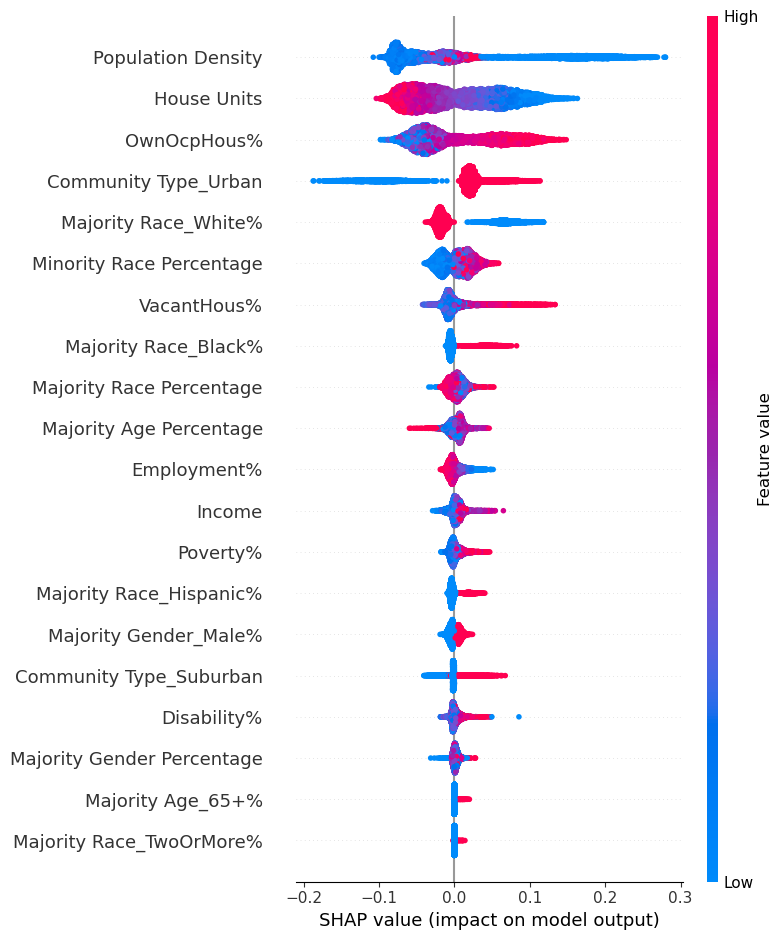

In [459]:
# Select SHAP values for class 1 (positive class)
shap_class_1 = shap_values[:, :, 1]

# Plot SHAP summary for class 1 -- bank deserts
shap.summary_plot(shap_class_1, X_test, show = False)

plt.savefig('summary_plot.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

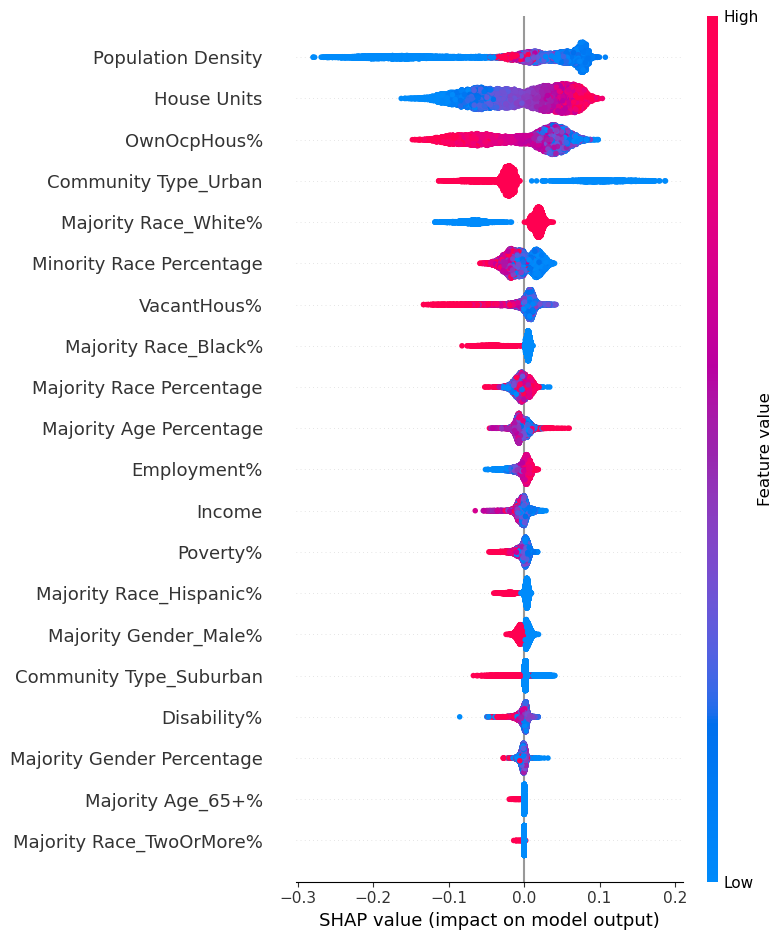

In [468]:
# Select SHAP values for class 0 (negative class)
shap_class_0 = shap_values[:, :, 0]

# Plot SHAP summary for class 0 -- bank deserts
shap.summary_plot(shap_class_0, X_test)

# plt.savefig('summary_plot.jpg', format='jpg', dpi=600, bbox_inches='tight')
# plt.show()

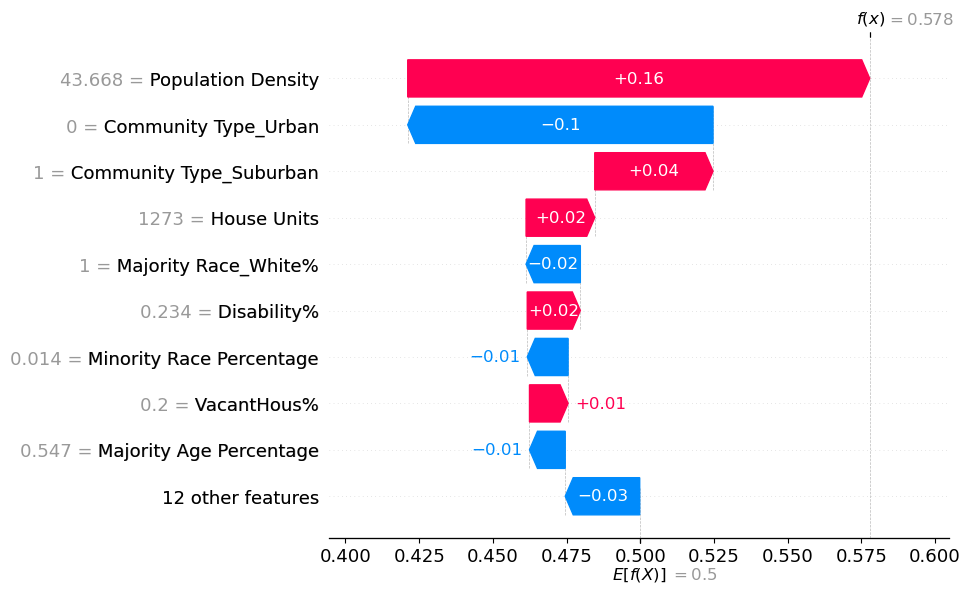

<Figure size 640x480 with 0 Axes>

In [461]:
# visualization of how shap works given one instance of data

# Select the first instance
instance_idx = 100
instance = X_test.iloc[instance_idx]

# Extract SHAP values for class 1 (positive class) for this instance
shap_values_instance = shap_values[instance_idx, :, 1]  # Shape: (n_features,)

# Create a SHAP Explanation object
shap_explainer_instance = shap.Explanation(values=shap_values_instance, 
                                           base_values=explainer.expected_value[1], 
                                           data=instance, 
                                           feature_names=X_test.columns.tolist())

# waterfall plot
shap.waterfall_plot(shap_explainer_instance)

plt.savefig('waterfall_plot.jpg', format='jpg', dpi=600, bbox_inches='tight')
plt.show()

The waterfall plot provides a detailed breakdown of how each input variable contributes towards the target variable given one instance of data.

The waterfall plot above shows how each features on the y-axis contributed to model predictions. The base value of (0.5) is the model's expected output before considering any features and the feature contributions (shap values) tells us whether a particular feature pushed the prediction up or down. In this particular instance, the features that pushed the predictions up are Population Density, Community Type_Suburban, House Units, Disability% and VacantHous%. Everything else pushed the prediction down. 

The f(x) in the x-axis is the base value and the f(x) on the y-axis is calculated as: 
Base value + sum of all shap values
0.5 + (0.16 - 0.1 + 0.04 + 0.02 - 0.02 + 0.02 - 0.01 + 0.01 + 0.01 - 0.01 - 0.03) is equal to 0.578. 